In [50]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import re
%matplotlib inline

In [95]:
def load_production_data(data_path="./"):
    
    production_train = []
    train_files = sorted(os.listdir(data_path+"/TrainingDataProduction/TrainingDataProduction"))
    train_files.sort(key=lambda f: (re.sub('\D', '', f)))
    for file in train_files:
        temp = pd.read_csv(data_path+"/TrainingDataProduction/TrainingDataProduction/"+file, sep=";")
        temp["ProcessCycle"] = float(file.split('.')[0])
        production_train.append(temp)

    production_train = pd.concat(production_train)

    production_valid = []
    valid_files = sorted(os.listdir(data_path+"/ValidationDataProduction/ValidationDataProduction"))
    valid_files.sort(key=lambda f: float(re.sub('\D', '', f)))
    for file in valid_files:
        temp = pd.read_csv(data_path+"/ValidationDataProduction/ValidationDataProduction/"+file, sep=";")
        temp["ProcessCycle"] = int(file.split('.')[0])
        production_valid.append(temp)

    production_valid = pd.concat(production_valid)
    
    production_test = []

    test_files = sorted(os.listdir(data_path+"/EvaluationDataProduction/EvaluationDataProduction"))
    test_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    for file in test_files:
        temp = pd.read_csv(data_path+"/EvaluationDataProduction/EvaluationDataProduction/"+file, sep=";")
        temp["ProcessCycle"] = int(file.split('.')[0])
        production_test.append(temp)

    production_test = pd.concat(production_test)
    
    production_train["Split"] = "Train"
    production_valid["Split"] = "Valid"
    
    production_train_val_combined = pd.concat([production_train, production_valid]).reset_index(drop=True)
    
    return production_train_val_combined, production_test

In [88]:
def load_data(data_path =  "./"):

    conveyor_train = pd.read_csv(data_path+"TrainingDataConveyor.csv")
    conveyor_valid = pd.read_csv(data_path+"ValidationDataConveyor.csv")

    coveyor_eval_data = []

    eval_files = os.listdir(data_path+"/EvaluationDataConveyor/EvaluationDataConveyor")
    eval_files.sort(key=lambda f: int(re.sub('\D', '', f)))

    for file in eval_files:
        temp = pd.read_csv(data_path+"/EvaluationDataConveyor/EvaluationDataConveyor/"+file)
        temp["ProcessCycle"] = int(file.split('.')[0])
        coveyor_eval_data.append(temp)

    coveyor_eval_data = pd.concat(coveyor_eval_data)

    # remove duplicate column
    # Only Once 
    # Only Conveyor train has the duplicate value [The deleted row and the very next row have the exact same values]
    conveyor_train.drop(244, axis=0, inplace=True)
    conveyor_train = conveyor_train.reset_index(drop=True)

    # Identify the cycles based on the Timestamp values
    def identify_cycle_start(val):
        if val == 0:
            return True
        else:
            return False

    def get_cycle_col(df):
        vals = []
        cycle = 0
        for val in df.ProcessCycle:
            if val == True:
                cycle += 1
            vals.append(cycle)
        cycles = pd.Series(vals)
        return cycles

    conveyor_train["ProcessCycle"] = conveyor_train["Timestamp"].apply(identify_cycle_start)
    conveyor_valid["ProcessCycle"] = conveyor_valid["Timestamp"].apply(identify_cycle_start)

    conveyor_train["ProcessCycle"] = get_cycle_col(conveyor_train)
    conveyor_valid["ProcessCycle"] = get_cycle_col(conveyor_valid)
    
    # Split column represents which split it is from
    conveyor_train["Split"] = "Train"
    conveyor_valid["Split"] = "Valid"

    conveyor_train_valid_joined = pd.concat([conveyor_train, conveyor_valid])
    
    return conveyor_train_valid_joined, coveyor_eval_data
    

In [2]:
df_test = pd.read_csv("ValidationDataConveyor.csv")
df_train = pd.read_csv("TrainingDataConveyor.csv")

In [32]:
df = pd.concat([df_train,df_test], axis=0)

In [96]:
df_train, df_eval = load_production_data()

OSError: Initializing from file failed

In [82]:
df_train = df_train.drop(["Split"], axis = 1)

In [83]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()

In [85]:
s.fit(df_train)
df_train = s.transform(df_train)


In [86]:
from sklearn.ensemble import IsolationForest
import numpy as np
np.random.seed(1)
random_data = np.random.randn(50000,2)  * 20 + 20

clf = IsolationForest( behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(df_train)

df_train["preds"] = preds

C:\Users\cyk\AppData\Roaming\Python\Python38\site-packages\sklearn\ensemble\_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [56]:
preds_eval = clf.fit_predict(df_eval)
df_eval["preds"] = preds_eval

C:\Users\cyk\AppData\Roaming\Python\Python38\site-packages\sklearn\ensemble\_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


In [74]:
df_eval["ProcessCycle"].loc[df_eval["preds"] == -1]


0       1
1       1
2       1
9       1
10      1
       ..
238    50
239    50
240    50
241    50
242    50
Name: ProcessCycle, Length: 2999, dtype: int64

In [10]:
# Find correlations with the target and sort
correlations = df.corr()['Labels'].sort_values()
print(correlations)

O_w_BRU_voltage   -0.061826
O_w_BRU_power     -0.059349
I_w_HR_Weg        -0.045347
I_w_HL_Weg        -0.044887
O_w_BLO_power     -0.015828
I_w_BLO_Weg       -0.001640
Timestamp          0.002542
O_w_BHL_power      0.002801
O_w_BLO_voltage    0.004648
I_w_BHL_Weg        0.007693
O_w_BHL_voltage    0.009582
O_w_BHR_power      0.010341
O_w_HL_power       0.024969
O_w_HR_power       0.031784
O_w_HL_voltage     0.032059
O_w_HR_voltage     0.032251
I_w_BHR_Weg        0.041197
O_w_BHR_voltage    0.041997
I_w_BRU_Weg        0.048364
Labels             1.000000
Name: Labels, dtype: float64


In [14]:
from sklearn.model_selection import train_test_split
#Init von Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(df.drop('Labels',axis=1), 
                                                    df['Labels'], test_size=0.30, 
                                                    random_state=101)

In [15]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import GridSearchCV

In [16]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)


In [17]:
clf = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, verbose=0)

In [20]:
#Erstellen und Fitten des Modells auf Trainingsdaten
logmodel = LogisticRegression(solver="liblinear", max_iter=250)
#logmodel = LogisticRegressionCV(cv= 5, class_weight="balanced")
logmodel.fit(X_train,y_train)
sgdmodel = SGDClassifier(loss="log")
sgdmodel.fit(X_train,y_train)
#Predictions
predictions = logmodel.predict(X_test)
sgd_pred = sgdmodel.predict(X_test)

In [21]:
from sklearn import metrics

In [22]:
def evaluation(predictions):
    #Auswertung durch Confusion Matrix und dem Built-In Report von Sklearn
    cnf_matrix = metrics.confusion_matrix(y_test,predictions)
    print(cnf_matrix)
    print("\n")
    print(metrics.classification_report(y_test, predictions))

    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


[[3929   10]
 [  94    6]]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3939
           1       0.38      0.06      0.10       100

    accuracy                           0.97      4039
   macro avg       0.68      0.53      0.55      4039
weighted avg       0.96      0.97      0.97      4039



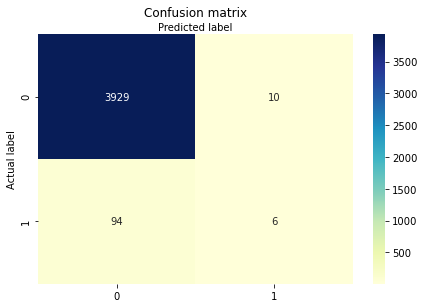

In [23]:
evaluation(predictions)

In [25]:
def evaluation_auc(model):
    #AUC als Performanceindikator der alle möglichen Thresholds aggregiert. Je höher der AUC, also die Fläche unter der ROC-Kurve ist,
    #desto besser kann eine Klasse bestimmt werden. Jedoch ist ein AUC von 0.5 ein Indiz für eine nicht erfolgreiche Bestimmung der Klassen
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

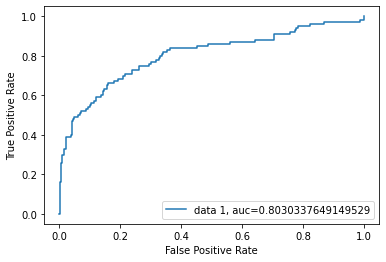

In [26]:
evaluation_auc(logmodel)